In [1]:
#uses pandas and then convert to list/dict
import pandas as pd 
import string
from string import punctuation
import re
import emoji
from nltk.tokenize import TweetTokenizer
import nltk
import numpy as np
import torch.nn as nn
import torch
from sklearn.utils import shuffle
from torch.nn import functional as F
import matplotlib.pyplot as plt
import scikitplot as skplt
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import itertools
import time
import contractions
import pickle
import os
import numpy as np
import sklearn.metrics as sm

**Load Datasets**

In [2]:
data_folder = 'data/'
#glove_folder = 'E:/rajiur/workspace/nlp/data/'
glove_folder = 'D:/workspace/nlp/glove/'

In [3]:
dftrain = pd.read_pickle('train_tokenized_df.pkl')
dfdev = pd.read_pickle('dev_tokenized_df.pkl')

In [4]:
dev_set = dfdev.to_dict('records')
train_set = dftrain.to_dict('records')

In [5]:
with open('vocabulary.pkl', 'rb') as filehandle:
    # read the data as binary data stream
    vocabulary = pickle.load(filehandle)

In [6]:
len(vocabulary)

22138

**Word Embedder**

In [7]:


class WordEmbedder(nn.Module):
    def __init__(self, vocab, glove_file, seqlen = 300, varlen = False):
        super(WordEmbedder, self).__init__()
        assert os.path.exists(glove_file) and glove_file.endswith('.txt'), glove_file
        
        self.emb_dim = None
        
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        self.sequence_length = seqlen
        self.various_length = varlen
        
        idx2word = [self.PAD_TOKEN, self.UNK_TOKEN]
        idx2vect = [None, None]
        
        with open(glove_file, 'r', encoding='utf-8') as fp:
            for line in fp:
                line = line.split()
                
                if line[0] not in vocab:
                    continue
                
                w = line[0]
                v = np.array([float(value) for value in line[1:]])
                
                if self.emb_dim is None:
                    self.emb_dim = v.shape[0]
            
                idx2word.append(w)
                idx2vect.append(v)
                
        idx2vect[0] = np.zeros(self.emb_dim)
        idx2vect[1] = np.mean(idx2vect[2:], axis=0)
    
        self.embeddings = torch.from_numpy(np.array(idx2vect)).float()
        self.embeddings = nn.Embedding.from_pretrained(self.embeddings, freeze=False)
        
        self.idx2word = {i: w for i, w in enumerate(idx2word)}
        self.word2idx = {w: i for i, w in self.idx2word.items()}
    
    def forward(self, samples):
        pad_idx = self.word2idx[self.PAD_TOKEN]
        unk_idx = self.word2idx[self.UNK_TOKEN]
        
        if self.various_length:

            #Find the length of the longest sample
            maxlen = max([len(s) for s in samples])
        
        else:

            #Use a constant length for all samples
            maxlen = self.sequence_length
        
        encoded = [[self.word2idx.get(token, unk_idx) for token in tokens] for tokens in samples]
        
        padded = np.zeros((len(samples), maxlen), dtype=int)
        masks = torch.zeros(len(samples), maxlen).long()
        
        # Padding and masking
        for i in range(len(encoded)):
            masks[i, :len(encoded[i])] = 1
            padded[i, :len(encoded[i])] = np.array(encoded[i])[:maxlen]
            # encoded[i] += [pad_idx] * max(0, (maxlen - len(encoded[i])))
        
        encoded = torch.tensor(padded).long()
        
        if torch.cuda.is_available():
            encoded = encoded.cuda()
            masks = masks.cuda()
        
        result = {
            'output': self.embeddings(encoded),
            'mask': masks,
            'encoded': encoded
        }
        
        return result

In [8]:
embedder = torch.load('embedder_glove_300d.pt')
embedder

WordEmbedder(
  (embeddings): Embedding(19447, 300)
)

**Helper Functions**

In [9]:
from sklearn.metrics import accuracy_score

def track_best_model(model_path, model, epoch, best_acc, dev_acc, dev_loss):
    if best_acc > dev_acc:
        return best_acc, ''
    state = {
        'epoch': epoch,
        'acc': dev_acc,
        'loss': dev_loss,
        'model': model.state_dict()
    }
    torch.save(state, model_path)
    return dev_acc, ' * '

def hot_target(batch_target):
    result = []
    for target in batch_target:
        init_target = [0,0,0]
        init_target[target]=1
        result.append(init_target)
    return result    

In [10]:
import random
from torch.nn import functional as F

def train(model, optimizer, shuffled_train_set, batch_size, loss_func="CE"):

    model.train()
    
    criterion = torch.nn.CrossEntropyLoss().to("cpu")
    total_loss = 0
    batch_tokens, batch_target = [], []

    random.Random(1234).shuffle(shuffled_train_set)

    for i in range(len(shuffled_train_set)):

        batch_tokens.append(shuffled_train_set[i]['tokens'])
        batch_target.append(shuffled_train_set[i]['labelnumber'])

        if len(batch_tokens) == batch_size or i == (len(shuffled_train_set) - 1):

            optimizer.zero_grad()

            out = model(batch_tokens)
            y_pred = out.cpu()

            if(loss_func=='CE'):
                #loss method 1: CrossEntropyLoss
                loss = criterion(y_pred, torch.tensor(batch_target))
            else:
                loss = torch.nn.functional.binary_cross_entropy(y_pred,torch.tensor(hot_target(batch_target)).float())
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            batch_tokens, batch_target = [], []
        
    return model, shuffled_train_set

In [11]:
def evaluate(model, dev_set, batch_size, loss_func='CE'):

    model.eval()
    criterion = torch.nn.CrossEntropyLoss().to("cpu")
    total_loss = 0
    accurate = 0
    batch_tokens, batch_target = [], []
    predictions, actual = [], []

    with torch.no_grad():
        for i in range(len(dev_set)):
            
            batch_tokens.append(dev_set[i]['tokens'])
            batch_target.append(dev_set[i]['labelnumber'])

            if len(batch_tokens) == batch_size or i == (len(dev_set)-1):

                out = model(batch_tokens)
                #print("out",out)
                y_pred = out.cpu()
                
                predictions.extend(y_pred.argmax(1).tolist())
                actual.extend(batch_target)
               
                if(loss_func=='CE'):
                    loss = criterion(y_pred, torch.tensor(batch_target))
                else:
                    loss = torch.nn.functional.binary_cross_entropy(y_pred,torch.tensor(hot_target(batch_target)).float())
                
                total_loss += loss.item()
                accurate += (y_pred.argmax(1) == torch.tensor(batch_target)).sum().item()
                
                 

                batch_tokens, batch_target = [], []

    return predictions, total_loss/len(dev_set), accurate/len(dev_set)

In [12]:
import torch.optim as optim
def training_loop(config, model_, train_set, dev_set, loss_func='CE'):

    model = model_
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])

    shuffled_train_set = train_set
    best_acc = 0
    

    for epoch in range(config['epoch']):

        epoch_msg = '[Epoch {}] / {}'.format(epoch+1, config['epoch'])

        model, shuffled_train_set = train(model, optimizer, shuffled_train_set, batch_size=64, loss_func=loss_func)

        train_pred, train_loss, train_acc = evaluate(model, shuffled_train_set, batch_size=128, loss_func=loss_func)
        epoch_msg += ' [TRAIN] Loss: {:.4f}, Acc: {:.4f}'.format(train_loss, train_acc)
        val_pred, val_loss, val_acc = evaluate(model, dev_set, batch_size=128, loss_func=loss_func)
        epoch_msg += ' [DEV] Loss: {:.4f}, Acc: {:.4f}'.format(val_loss, val_acc)
        #test_pred, test_loss, test_acc = evaluate(model, test_set, batch_size=128)
        #epoch_msg += ' [TEST] Loss: {:.4f}, Acc: {:.4f}'.format(test_loss, test_acc)

        best_acc, epoch_track = track_best_model(config['checkpoint'], model, epoch, best_acc, val_acc, val_loss)
        print(epoch_msg + epoch_track)

    print('Done Training!')

    state = torch.load(config['checkpoint'])
    model.load_state_dict(state['model'])

    print('Returning best model from epoch {} with loss {:.5f} and accuracy {:.5f}'.format(state['epoch'], state['loss'], state['acc']))
    return model

**BiGRU**

In [13]:
  class BiGRULayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(BiGRULayer, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim // 2, bidirectional=True, dropout = 0.1, num_layers = 3)

    def forward(self, vectors, mask):
        batch_size = vectors.size(0)
        maxlen = vectors.size(1)
        lengths = mask.sum(-1)
        
        gru_out, _ = self.gru(vectors)  # (batch, seq_len, hidden_dim)
        
        assert gru_out.size(0) == batch_size
        assert gru_out.size(1) == maxlen
        assert gru_out.size(2) == self.hidden_dim

        # Separate the directions of the GRU
        gru_out = gru_out.view(batch_size, maxlen, 2, self.hidden_dim // 2)

        # Pick up the last hidden state per direction
        fw_last_hn = gru_out[range(batch_size), lengths - 1, 0]  # (batch, hidden // 2)
        bw_last_hn = gru_out[range(batch_size), 0, 1]            # (batch, hidden // 2)
        
        last_hn = torch.cat([fw_last_hn, bw_last_hn], dim=1)      # (batch, hidden // 2) -> (batch, hidden)

        return {'output': last_hn, 'outputs': gru_out}

In [14]:
class MyClassifier(nn.Module):
    def __init__(self, embedder, extractor):
        super(MyClassifier, self).__init__()
        self.embedder = embedder
        self.extractor = extractor
        self.classifier = nn.Linear(extractor.hidden_dim, 3)
        #self.fc1 = nn.Linear(extractor.hidden_dim, 128)
        #self.fc2 = nn.Linear(128, 64)
        #self.classifier = nn.Linear(64, 3)
        
    def forward(self, tokens, targets=None):
        embedded = self.embedder(tokens)
        extracted = self.extractor(embedded['output'], embedded['mask'])
        
        #print(type(self.classifier(extracted['output'])),self.classifier(extracted['output']).shape,self.classifier(extracted['output']))
        #print(type(torch.sigmoid(self.classifier(extracted['output']))), torch.sigmoid(self.classifier(extracted['output'])).shape, torch.sigmoid(self.classifier(extracted['output'])))
        #print(torch.softmax(self.classifier(extracted['output']), dim=1))
        
        #x = self.fc1(extracted['output'])
        #x = self.fc2(x)
        #output = torch.softmax(self.classifier(x),dim=1)
        output = torch.softmax(self.classifier(extracted['output']), dim=1)
       
        return output

In [15]:
bigru_layer = BiGRULayer(embedder.emb_dim, 128)
bigru_layer

BiGRULayer(
  (gru): GRU(300, 64, num_layers=3, dropout=0.1, bidirectional=True)
)

In [16]:
bigru_model = MyClassifier(embedder, bigru_layer)
bigru_model

MyClassifier(
  (embedder): WordEmbedder(
    (embeddings): Embedding(19447, 300)
  )
  (extractor): BiGRULayer(
    (gru): GRU(300, 64, num_layers=3, dropout=0.1, bidirectional=True)
  )
  (classifier): Linear(in_features=128, out_features=3, bias=True)
)

In [29]:
config = {
    'lr': 0.2,#1e-3,
    'momentum': 0.9, #0.99,
    'epoch': 100,
    'checkpoint': 'bigru_model.pt'
}
model3 = training_loop(config, bigru_model, train_set, dev_set)

[Epoch 1] / 100 [TRAIN] Loss: 0.0082, Acc: 0.4698 [DEV] Loss: 0.0085, Acc: 0.4515 * 
[Epoch 2] / 100 [TRAIN] Loss: 0.0080, Acc: 0.4848 [DEV] Loss: 0.0083, Acc: 0.4700 * 
[Epoch 3] / 100 [TRAIN] Loss: 0.0079, Acc: 0.5209 [DEV] Loss: 0.0082, Acc: 0.4725 * 
[Epoch 4] / 100 [TRAIN] Loss: 0.0079, Acc: 0.5172 [DEV] Loss: 0.0083, Acc: 0.4600
[Epoch 5] / 100 [TRAIN] Loss: 0.0077, Acc: 0.5436 [DEV] Loss: 0.0083, Acc: 0.4790 * 
[Epoch 6] / 100 [TRAIN] Loss: 0.0076, Acc: 0.5671 [DEV] Loss: 0.0082, Acc: 0.4790 * 
[Epoch 7] / 100 [TRAIN] Loss: 0.0079, Acc: 0.5126 [DEV] Loss: 0.0085, Acc: 0.4600
[Epoch 8] / 100 [TRAIN] Loss: 0.0073, Acc: 0.6099 [DEV] Loss: 0.0084, Acc: 0.4660
[Epoch 9] / 100 [TRAIN] Loss: 0.0072, Acc: 0.6315 [DEV] Loss: 0.0083, Acc: 0.4785
[Epoch 10] / 100 [TRAIN] Loss: 0.0072, Acc: 0.6248 [DEV] Loss: 0.0085, Acc: 0.4710
[Epoch 11] / 100 [TRAIN] Loss: 0.0071, Acc: 0.6418 [DEV] Loss: 0.0084, Acc: 0.4710
[Epoch 12] / 100 [TRAIN] Loss: 0.0072, Acc: 0.6296 [DEV] Loss: 0.0085, Acc: 0.465

In [18]:
train_tokens = [row['tokens'] for index,row in dftrain.iterrows()]
dev_tokens = [row['tokens'] for index,row in dfdev.iterrows()]

In [19]:
class2index = {'OAG':2,'CAG':0,'NAG':1}
index2class = {2:'OAG',0:'CAG',1:'NAG'}

In [37]:
out = model3(dev_tokens)
dev_pred = out.cpu().argmax(1).tolist()

NameError: name 'index2class' is not defined

In [20]:
dev_label=[]
for i in range(len(dev_set)):
    dev_label.append(dev_set[i]['labelnumber'])

dev_label_class = [index2class[x]  for x in dev_label]

In [ ]:
dev_pred_class = [index2class[x]  for x in dev_pred]

In [42]:
print(dev_label_class[:20])
print(dev_pred_class[:20])

['CAG', 'NAG', 'NAG', 'NAG', 'OAG', 'CAG', 'NAG', 'CAG', 'CAG', 'CAG', 'NAG', 'NAG', 'NAG', 'OAG', 'CAG', 'CAG', 'CAG', 'CAG', 'OAG', 'NAG']
['NAG', 'CAG', 'OAG', 'NAG', 'CAG', 'CAG', 'CAG', 'CAG', 'CAG', 'NAG', 'CAG', 'NAG', 'NAG', 'CAG', 'NAG', 'NAG', 'CAG', 'CAG', 'OAG', 'NAG']


In [45]:
target_names = ['OAG', 'NAG', 'CAG']
print(sm.classification_report(dev_label_class, dev_pred_class,target_names=target_names))

              precision    recall  f1-score   support

         OAG       0.41      0.53      0.46       700
         NAG       0.55      0.59      0.57       815
         CAG       0.48      0.21      0.30       485

    accuracy                           0.48      2000
   macro avg       0.48      0.45      0.44      2000
weighted avg       0.48      0.48      0.47      2000



In [46]:
print(sm.confusion_matrix(dev_label_class, dev_pred_class, labels=['OAG', 'CAG', 'NAG']) )

[[104 246 135]
 [ 67 370 263]
 [ 46 285 484]]


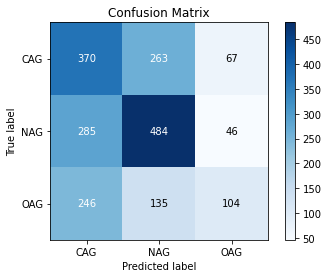

In [47]:

skplt.metrics.plot_confusion_matrix(dev_label_class, dev_pred_class, normalize=False)
plt.show()

**Saving predictions**

In [52]:
dftest = pd.read_pickle('test_tokenized_df.pkl')

In [53]:
test_set = dftest.to_dict('records')

In [54]:
len(test_set)

1001

In [57]:
def test(model_, test_set_, batch_size_):
    model = model_
    model_.eval()
    criterion = torch.nn.CrossEntropyLoss().to("cpu")

    batch_tokens = []
    predictions = []
    batch_count = 0

    with torch.no_grad():
        for i in range(len(test_set_)):
            
            batch_tokens.append(test_set_[i]['tokens'])

            if len(batch_tokens) == batch_size_ or i == (len(test_set_)-1):
                batch_count+=1
                out = model(batch_tokens)
                #print("out",out)
                y_pred = out.cpu()
                #print("y_pred",y_pred)

                predictions.extend(y_pred.argmax(1).tolist())
                
                #print(batch_count,len(batch_tokens))
                batch_tokens = []
                
    
    #print("evaluate actual",actual)
    #print("evaluate predic",predictions)
    #accuracy = accuracy_score(actual, predictions)
    
    #print(accurate,len(test_set_))
    
    #print("evaluate loss",total_loss/len(test_set), "accurary",accurate/len(test_set))

    return predictions

In [58]:
predictions = test(model3,test_set, 128)

1 128
2 128
3 128
4 128
5 128
6 128
7 128
8 105


In [59]:
len(predictions)

1001

In [60]:
predictedlabels = [index2class[x] for x in predictions]

In [61]:
len(predictedlabels), len(dftest)

(1001, 1001)

In [62]:
dftest['Label'] = predictedlabels

In [63]:
dftest[['ID','Label']].head()

,ID,Label
0,facebook_corpus_msr_495558,CAG
1,facebook_corpus_msr_1561809,CAG
2,facebook_corpus_msr_442487,CAG
3,facebook_corpus_msr_495517,NAG
4,facebook_corpus_msr_1805455,CAG


In [64]:
dftest.to_csv('prediction_bigru_all.csv',index=False)

**Analysis**

In [21]:
state = torch.load('bigru_model.pt')
bigru_model.load_state_dict(state['model'])

<All keys matched successfully>

In [22]:
dev_tokens[:2]

[['the',
  'quality',
  'of',
  're',
  'made',
  'now',
  'makes',
  'me',
  'think',
  'it',
  'is',
  'something',
  'to',
  'be',
  'bought',
  'from',
  'fish',
  'market'],
 ['siva',
  'how',
  'is',
  'ur',
  'mother',
  'how',
  'is',
  'ur',
  'wife',
  'how',
  'is',
  'ur',
  'sister',
  'hope',
  'everyone',
  'is',
  'fine']]

In [23]:
out =  bigru_model(dev_tokens)
dev_pred = out.cpu().argmax(1).tolist()

In [24]:
dev_pred[:2]

[1, 0]

In [25]:
dev_pred_class = [index2class[x]  for x in dev_pred]

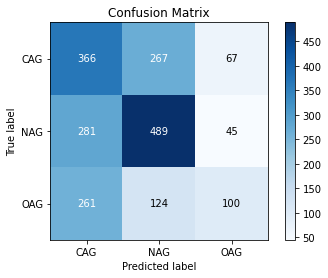

In [27]:

skplt.metrics.plot_confusion_matrix(dev_label_class, dev_pred_class, normalize=False)
plt.show()

In [26]:
pd.DataFrame(dev_pred_class).to_csv('dev_prediction_bigru.csv',index=False)